<a href="https://colab.research.google.com/github/gyeongee/TIL/blob/main/TIL_250821.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
%cd '/content/drive/MyDrive/Colab Notebooks/인사교_8월미니프로젝트'

/content/drive/MyDrive/Colab Notebooks/인사교_8월미니프로젝트


In [43]:
!ls

data  deepfake-detection-clip-gnn.ipynb  deepfake_gnn_model.pth  dmsrud  key


In [45]:
from huggingface_hub import login
with open("./key/huggingface_api_key",'r') as f:
  api_key = f.read().strip()

  login(token=api_key)

In [1]:
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install transformers
!pip install opencv-python
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 318.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.3 MB/s eta 0:00:00


In [26]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torch_geometric.data import Data as GeoData, Batch
from torch_geometric.nn import GCNConv, global_mean_pool
from transformers import CLIPProcessor, CLIPModel

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt


In [27]:
# Hyperparameters
BATCH_SIZE = 4
LR = 0.0001
EPOCHS = 5
PATCH_SIZE = 32
CLIP_DIM = 512 # 입력 feature size: 196×512
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [22]:
from transformers import CLIPModel

# 1. CLIP 모델 불러오기
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor=CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [29]:
# GNN Model Definition --------------------------------------------------
class DeepfakeGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        # 마지막 classification layer
        # 1 (이진 분류: real/fake)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        # 그래프 단위로 feature 평균 pooling
        # batch: 노드별로 어떤 그래프에 속하는지 나타내는 인덱스
        x = global_mean_pool(x, batch)
        return self.fc(x).squeeze(-1)

In [30]:
# Initialize GNN
model = DeepfakeGNN(CLIP_DIM, 256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()

In [31]:
# Data Processing ---------------------------------------------------
def extract_patches(image_tensor, patch_size=PATCH_SIZE):
    """Convert image tensor to patches"""
    patches = []
    coords = []
    for i in range(0, 224, patch_size):
        for j in range(0, 224, patch_size):
            patch = image_tensor[:, i:i+patch_size, j:j+patch_size]
            patches.append(patch)
            coords.append([i, j])
    return patches, coords

def create_graph(coords, threshold=1.5*PATCH_SIZE):
    """Create edges between nearby patches"""
    edges = []
    for i, (x1, y1) in enumerate(coords):
        for j, (x2, y2) in enumerate(coords):
            if ((x1-x2)**2 + (y1-y2)**2) <= threshold**2:
                edges.append([i, j])
    return torch.tensor(edges, dtype=torch.long).t().contiguous()

In [32]:
# Custom Dataset

class DeepfakeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = datasets.ImageFolder(root_dir, transform=transform)
        self.classes = self.dataset.classes

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        # 1. Extract patches
        patches, coords = extract_patches(img)

        # 2. Convert patches to numpy images for CLIP
        images = []
        for p in patches:
            np_patch = (p.detach().cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
            images.append(np_patch)

        # 3. CLIP features
        with torch.no_grad():
            inputs = clip_processor(images=images, return_tensors="pt", padding=True).to(device)
            patch_features = clip_model.get_image_features(**inputs)

        # 4. Graph
        edge_index = create_graph(coords)

        return GeoData(
            x=patch_features,
            edge_index=edge_index,
            y=torch.tensor(label, dtype=torch.float)
        )

In [33]:
# Initialize datasets
train_dir = "./data/test-20250112T065939Z-001/test"
test_dir = "./data/train-20250112T065955Z-001/train"

train_dataset = DeepfakeDataset(train_dir, transform=transform)
test_dataset = DeepfakeDataset(test_dir, transform=transform)

In [34]:
# Create loaders
def collate_fn(batch):
    return Batch.from_data_list(batch)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [35]:
# Training Loop -----------------------------------------------------
print("Starting training...")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    print(f"\nEpoch {epoch + 1}/{EPOCHS}...")

    for i, batch in enumerate(train_loader):

        batch = batch.to(device)
        optimizer.zero_grad()

        outputs = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(outputs, batch.y)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"\nEpoch {epoch + 1} finished — Loss: {avg_loss:.4f}")

print("\nTraining complete!")

Starting training...

Epoch 1/5...


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 1 finished — Loss: 0.5576

Epoch 2/5...

Epoch 2 finished — Loss: 0.4643

Epoch 3/5...

Epoch 3 finished — Loss: 0.4169

Epoch 4/5...

Epoch 4 finished — Loss: 0.4034

Epoch 5/5...

Epoch 5 finished — Loss: 0.3741

Training complete!



Test Metrics:
Accuracy:  0.6033
Precision: 0.8953
Recall:    0.4724
F1 Score:  0.6185


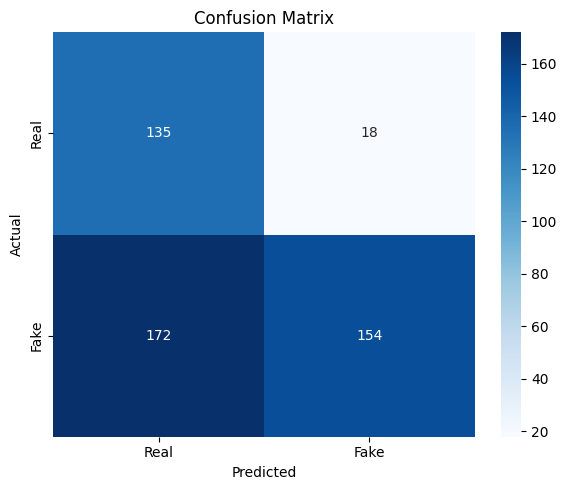

In [36]:
# Evaluation --------------------------------------------------------
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)

        outputs = model(batch.x, batch.edge_index, batch.batch)
        preds = (torch.sigmoid(outputs) > 0.5).long()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch.y.long().cpu().numpy())

# Metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, zero_division=0)
rec = recall_score(all_labels, all_preds, zero_division=0)
f1 = f1_score(all_labels, all_preds, zero_division=0)
conf_mat = confusion_matrix(all_labels, all_preds)

# Print metrics
print(f"\nTest Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [37]:
import os
output_dir='.result/deepfake_model_clip'
os.makedirs(output_dir, exist_ok=True)  # 디렉토리 없으면 생성

save_path = os.path.join('', "deepfake_gnn_model.pth")
torch.save(model.state_dict(), save_path)   # 모델 파라미터 저장
print(f"Model saved to {save_path}")

Model saved to .result/deepfake_model_clip/deepfake_gnn_model.pth


In [48]:
from huggingface_hub import upload_file
from huggingface_hub import create_repo, upload_file
# 1. 레포지토리 생성 (없으면 새로 만듦)
repo_id = "dmsrud/deepfake_model_clip"
create_repo(repo_id, exist_ok=True)  # exist_ok=True면 이미 있어도 에러 안 남

torch.save(model.state_dict(), "deepfake_gnn_model.pth")

# 2. Hub에 업로드
repo_id = "dmsrud/deepfake_model_clip"
upload_file(
    path_or_fileobj="deepfake_gnn_model.pth",
    path_in_repo="deepfake_gnn_model.pth",
    repo_id=repo_id
)

deepfake_gnn_model.pth:   0%|          | 0.00/793k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/dmsrud/deepfake_model_clip/commit/9ace14604e5771dbe45821002ab41564cfd0ab16', commit_message='Upload deepfake_gnn_model.pth with huggingface_hub', commit_description='', oid='9ace14604e5771dbe45821002ab41564cfd0ab16', pr_url=None, repo_url=RepoUrl('https://huggingface.co/dmsrud/deepfake_model_clip', endpoint='https://huggingface.co', repo_type='model', repo_id='dmsrud/deepfake_model_clip'), pr_revision=None, pr_num=None)

In [ ]:
/content/drive/MyDrive/Colab Notebooks/인사교_8월미니프로젝트/data/test-20250112T065939Z-001/test/fake/0.jpg

In [67]:
import cv2

#cap = cv2.VideoCapture("../인사교_Agent/UCF101_subset/test/BenchPress/v_BenchPress_g05_c02.avi")
cap = cv2.VideoCapture("./data/test-20250112T065939Z-001/test/fake/0.jpg")
frames = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    # OpenCV는 BGR이므로 RGB로 변환
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)

cap.release()


In [68]:
import torch
from torchvision import transforms

# CLIP 모델이나 CNN에 맞춘 transform
transform = transforms.Compose([
    transforms.ToPILImage(),           # NumPy 배열 → PIL 이미지
    transforms.Resize((224, 224)),     # 모델 입력 크기
    transforms.ToTensor(),             # PIL → Tensor (C,H,W)
    transforms.Normalize(              # CLIP용 정규화 (예시)
        mean=[0.48145466, 0.4578275, 0.40821073],
        std=[0.26862954, 0.26130258, 0.27577711]
    )
])

frame_tensors = [transform(frame) for frame in frames]  # 리스트 of tensors

# 배치 차원 추가 (N, C, H, W)
frame_tensors = torch.stack(frame_tensors)


In [ ]:
/content/drive/MyDrive/Colab Notebooks/인사교_8월미니프로젝트/deepfake-detection-clip-gnn.ipynb

In [69]:
from transformers import CLIPModel, CLIPProcessor

# 학습한 모델 허깅스페이스에서 가져오기
clip_model = CLIPModel.from_pretrained("dmsrud/deepfake_model_clip")
clip_model.eval()

with torch.no_grad():
    # 배치 입력
    features = clip_model.get_image_features(frame_tensors)  # (num_frames, feature_dim)


In [70]:
import torch
from torch_geometric.data import Data

# 노드(feature) 정의
x = features  # shape = (num_frames, feature_dim)

# edge_index 생성 (간단한 순차 연결: frame i → frame i+1)
num_frames = x.size(0)
edge_index = torch.tensor(
    [[i for i in range(num_frames-1)] + [i+1 for i in range(num_frames-1)],
     [i+1 for i in range(num_frames-1)] + [i for i in range(num_frames-1)]],
    dtype=torch.long
)  # shape = (2, 2*(num_frames-1))

# PyG 데이터 객체 생성
graph = Data(x=x, edge_index=edge_index)


In [71]:
import torch.nn as nn
from torch_geometric.nn import GCNConv, global_mean_pool

class DeepfakeGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        # 모든 노드 feature 평균(pooling)
        x = global_mean_pool(x, torch.zeros(x.size(0), dtype=torch.long))
        x = self.fc(x)
        return x

# 모델 초기화
gnn_model = DeepfakeGNN(in_channels=features.size(1), hidden_channels=256, out_channels=2)
gnn_model.eval()


DeepfakeGNN(
  (conv1): GCNConv(512, 256)
  (conv2): GCNConv(256, 256)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

예측 잘 되는데??


In [65]:
with torch.no_grad():
    out = gnn_model(graph)  # shape = (batch=1, num_classes)
    pred = torch.argmax(out, dim=1)
    print("예측 클래스:", pred.item())


예측 클래스: 1


In [72]:
with torch.no_grad():
    out = gnn_model(graph)  # shape = (batch=1, num_classes)
    pred = torch.argmax(out, dim=1)
    print("예측 클래스:", pred.item())

예측 클래스: 0


In [66]:
# 클래스 맵 정의
class_map = {0: False, 1: True}

# pred가 Tensor인 경우
pred_label = class_map[pred.item()]

print("예측 클래스:", pred_label)


예측 클래스: True
